In [151]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
%matplotlib notebook
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def convert_df_columns(df):
    df_converted = pd.DataFrame()
    
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            # Convert datetime to Unix timestamp (float)
            df_converted[col] = df[col].astype('int64') / 1e9
        elif pd.api.types.is_string_dtype(df[col]):
            # Apply one-hot encoding to string columns
            df_converted = pd.concat([df_converted, pd.get_dummies(df[col], prefix=col)], axis=1)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Leave numeric columns as is
            df_converted[col] = df[col]
        else:
            try:
                # Try converting to int first
                df_converted[col] = df[col].astype(int)
            except ValueError:
                try:
                    # If int conversion fails, try converting to float
                    df_converted[col] = df[col].astype(float)
                except ValueError:
                    print(f"Column {col} cannot be converted to int or float.")

    return df_converted

def drop_all_nan_columns(df):
    # Identify columns where all values are NaN
    columns_to_drop = df.columns[df.isna().all()]

    # Drop these columns
    df_cleaned = df.drop(columns=columns_to_drop)

    # Convert columns_to_drop to a list for easy use
    dropped_columns_list = columns_to_drop.tolist()

    # Optionally, report how many and which columns were dropped
    if dropped_columns_list:
        print(f"Dropped columns: {dropped_columns_list}")
    else:
        print("No columns were dropped.")

    return df_cleaned, dropped_columns_list


def train_lstm_on_dfs(df_dict, input_columns, output_columns, batch_size=32, epochs=1):
    # Initialize the LSTM model
    
    
    # Initialising the RNN
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 80, return_sequences = True, input_shape=(1, len(input_columns))))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 80, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 80, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 80))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = 3))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    '''
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(1, len(input_columns))),  # Adjust the input shape
        Dense(len(output_columns))  # Adjust the output layer based on the number of output columns
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    '''
    print('starting')
    # Iterate over each dataframe in the dictionary
    for df in df_dict.values():
        print('Blip. Starting to train on: ')
        #df=convert_df_columns(df) --> memory error. 
        [df,dropped_columns]=drop_all_nan_columns(df)
        input_columns = [col for col in input_columns if col not in dropped_columns]

        df=df.ffill()
        df=df.dropna()
        # Preprocess the data for LSTM
        # Scale each input column and combine them
        #display(df)
        scaler = StandardScaler()
        X_scaled = np.array([scaler.fit_transform(df[col].values.reshape(-1, 1)) for col in input_columns])
        X_scaled = np.transpose(X_scaled, (1, 0, 2)).reshape(-1, 1, len(input_columns))

        # Prepare output data
        y = df[output_columns].values

        # Split the data into training and validation
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        
        # Train the model on the data from the current dataframe
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

        # Print the MAE for the last epoch
        last_mae = history.history['val_loss'][-1]
        print(f"MAE for the current dataframe: {last_mae}")

    print('Training completed.')
    # Return the trained model
    return model, scaler

def train_lstm_on_combined_dfs(df_dict, input_columns, output_columns, batch_size=32, epochs=1,sampling_step=1200):
    # Combine all dataframes for scaling
    combined_df = pd.concat([df.iloc[48:48+sampling_step] for df in df_dict.values()], axis=0) #48 so that avoids nan

    # Drop all NaN columns from the combined dataframe
    combined_df = combined_df.dropna(axis=1, how='all')
    input_columns = [col for col in input_columns if col in combined_df.columns]

    # Fit the scaler on the entire dataset
    scaler = StandardScaler()
    combined_df[input_columns] = scaler.fit_transform(combined_df[input_columns])

    # Initialize the LSTM model
    model = Sequential([
        LSTM(80, return_sequences=True, input_shape=(1, len(input_columns))),
        Dropout(0.2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(80),
        Dropout(0.2),
        Dense(len(output_columns))
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')

    print('Starting training')
    
    # Iterate over each dataframe in the dictionary for training
    for key, df in df_dict.items():
        print(f'Training on dataframe: {key}')

        # Apply the transformation with the fitted scaler
        df[input_columns] = scaler.transform(df[input_columns].fillna(method='ffill'))

        # Prepare input and output data
        X_scaled = df[input_columns].values.reshape(-1, 1, len(input_columns))
        y = df[output_columns].values

        # Split the data into training and validation
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Train the model on the data from the current dataframe
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

        # Print the MAE for the last epoch
        last_mae = history.history['val_loss'][-1]
        print(f"MAE for dataframe {key}: {last_mae}")

    print('Training completed.')

    # Return the trained model and the scaler
    return model, scaler


# Example usage:
# file_list = ['batch1.csv', 'batch2.csv', ...]  # List of filenames
# directory = '/path/to/directory'
# input_columns = ['input1', 'input2', ...]  # List of input column names
# output_columns = ['output1', 'output2', ...]  # List of output column names
# model = train_lstm_on_files(file_list, directory, input_columns, output_columns)


##WITHOUT GRIDSEARCH
##cosa succede se cambio in nn??
def initialize_model(input_columns,output_columns,M1,M2,T):
    
    model_0 = Sequential([
        LSTM(M1, return_sequences=True, input_shape=(T, len(input_columns))),
        Dropout(0.1),
        LSTM(M1, return_sequences=False),
        Dropout(0.1),
        Dense(M2, activation='relu'),
        Dense(len(output_columns), activation='linear')
    ])
    return model_0

def create_lstm_input_with_output(data, T, output_col_index):
    """
    Convert a dataset into a format suitable for LSTM training, including past output values.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: A 3D array suitable for LSTM training, with shape (N, T, D).
    """
    N = len(data) - T
    D = data.shape[1]
    X = np.zeros((N, T, D))
    
    for i in range(N):
        X[i, :, :-1] = data[i:i+T, :-1]  # Input features up to time t
        X[i, 1:, -1] = data[i:i+T-1, output_col_index]  # Output feature up to time t-1
        # Note: First element of output feature is not set, defaults to zero

    return X

def create_lstm_input(data, T, output_col_index):
    """
    Convert a dataset into a format suitable for LSTM training, including past output values.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: A 3D array suitable for LSTM training, with shape (N, T, D).
    """
    N = len(data) - T
    D = data.shape[1]
    X = np.zeros((N, T, D))
    
    for i in range(N):
        X[i, :, :] = data[i:i+T, :]  # Input features up to time t
        #X[i, 1:, -1] = data[i:i+T-1, output_col_index]  # Output feature up to time t-1
        # Note: First element of output feature is not set, defaults to zero

    return X


def create_output_array(data, T, output_col_index):
    """
    Create the output array for LSTM training.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: Output array for LSTM training.
    """
    # The output value for each sequence is the output at time t (end of the sequence)
    y = data[T:, output_col_index]

    return y

def create_in_and_out(df,T,input_col,output_col):
    N = len(df) - T -1
    D = len(input_col+output_col)
    X = np.zeros((N, T+1, D))
    Y=np.zeros(N)

    for t in range(N):
        x=df[input_col].iloc[t:t+T+1] #all data from t to t+T included
        x_tar=df[output_col].iloc[t:t+T]  #all targets ffrom t to t+T EXCLUDED

        x_tar=pd.concat([x_tar,pd.DataFrame(x_tar.iloc[0].values,columns=x_tar.columns)], ignore_index=True)#inpute the last value as the first to match dimensions
        #x=pd.concat([x,x_tar], ignore_index=True,axis=1) #unite the two
        x[output_col]=x_tar.values

        X[t, :, :]=x.values
        
        y=df[output_col].iloc[t+T]
        Y[t]=y.values
    return(X,Y)
        
        

def create_in_and_out_optimized(df, T, input_col, output_col):
    # Convert to numpy for faster operations
    input_data = df[input_col].values
    output_data = df[output_col].values

    N = len(df) - T - 1
    D = len(input_col) + len(output_col)
    X = np.zeros((N, T + 1, D))
    Y = np.zeros(N)

    for t in range(N):
        # Extract input data for current window
        x = input_data[t:t + T + 1]

        # Extract output data for current window, and append the last row
        x_tar = output_data[t:t + T]
        x_tar_with_last = np.vstack([x_tar, x_tar[-1]])

        # Combine input and modified output data
        combined_data = np.hstack([x, x_tar_with_last])

        # Assign to X
        X[t, :, :] = combined_data

        # Assign to Y
        Y[t] = output_data[t + T]

    return X, Y




-11 25


In [2]:
save_id='3pui'
df_dict=joblib.load(r"./train_dataset_complete_{}.pkl".format(save_id))



3
4
5
8
10
13
14
17


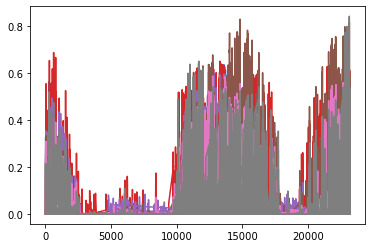

In [87]:
for key, df in df_dict.items():
    print(key)
    #plt.plot(df['target'])
    #plt.show()
    
    plt.plot(df['target_normalized'])
plt.show()

(2000, 279)
['county', 'weekday', 'hour_of_day', 'day_of_month', 'month', 'es_festive', 'eic_count', 'temperature_f', 'dewpoint_f', 'cloudcover_high_f', 'cloudcover_low_f', 'cloudcover_mid_f', 'cloudcover_total_f', '10_metre_u_wind_component_f', '10_metre_v_wind_component_f', 'direct_solar_radiation_f', 'surface_solar_radiation_downwards_f', 'snowfall_f', 'total_precipitation_f', 'hours_ahead_f', 'euros_per_mwh']
Starting training
Training on dataframe: 3
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 525s 887ms/step - loss: 0.1602 - val_loss: 0.2788
MAE for the current dataframe: 0.27881765365600586
142/142 [==============================] - 26s 174ms/step


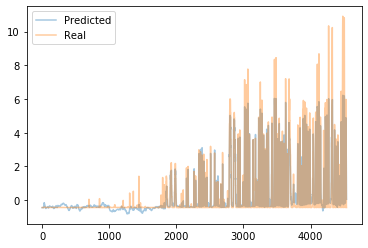

Training on dataframe: 4
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 3591s 6s/step - loss: 0.3312 - val_loss: 0.5255
MAE for the current dataframe: 0.5255197882652283
142/142 [==============================] - 25s 174ms/step


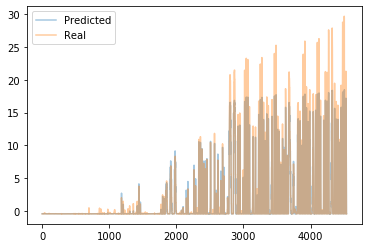

Training on dataframe: 5
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 468s 813ms/step - loss: 2.3370 - val_loss: 5.0240
MAE for the current dataframe: 5.024001121520996
142/142 [==============================] - 24s 168ms/step


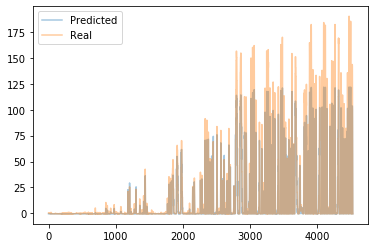

Training on dataframe: 8
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 439s 765ms/step - loss: 0.1068 - val_loss: 0.1167
MAE for the current dataframe: 0.1166619062423706
142/142 [==============================] - 19s 132ms/step


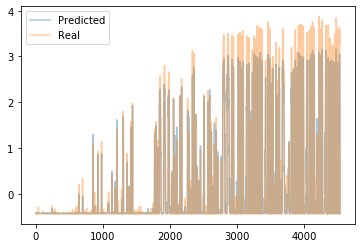

Training on dataframe: 10
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 420s 731ms/step - loss: 0.1942 - val_loss: 0.4042
MAE for the current dataframe: 0.4041845202445984
142/142 [==============================] - 19s 132ms/step


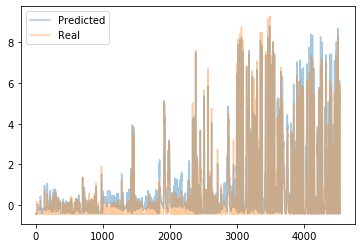

Training on dataframe: 13
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 417s 726ms/step - loss: 0.0501 - val_loss: 0.0638
MAE for the current dataframe: 0.06376273185014725
142/142 [==============================] - 19s 132ms/step


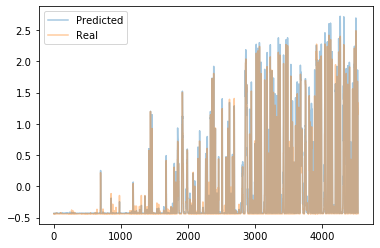

Training on dataframe: 14
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 408s 710ms/step - loss: 0.3790 - val_loss: 0.5743
MAE for the current dataframe: 0.5743148326873779
142/142 [==============================] - 18s 128ms/step


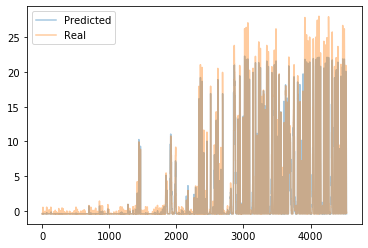

Training on dataframe: 17
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 400s 696ms/step - loss: 0.2100 - val_loss: 0.2755
MAE for the current dataframe: 0.27551695704460144
142/142 [==============================] - 19s 132ms/step


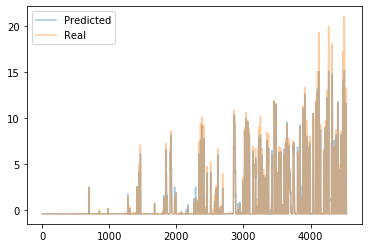

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-12-28 13:34:41         3374
metadata.json                                  2023-12-28 13:34:41           64

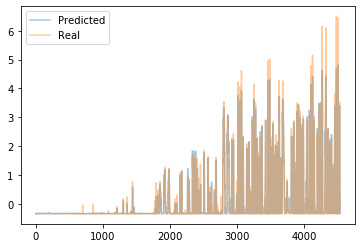

Training on dataframe: 4
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 532s 926ms/step - loss: 0.1375 - val_loss: 0.2583
MAE for the current dataframe: 0.2583496868610382
142/142 [==============================] - 24s 170ms/step


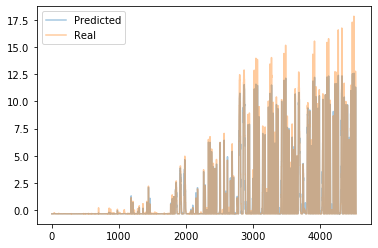

Training on dataframe: 5
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 504s 878ms/step - loss: 1.1614 - val_loss: 2.2548
MAE for the current dataframe: 2.254753589630127
142/142 [==============================] - 29s 203ms/step


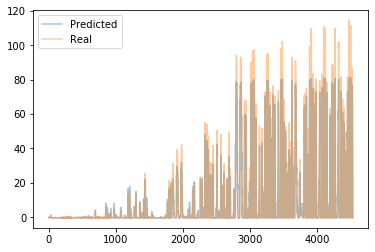

Training on dataframe: 8
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 490s 854ms/step - loss: 0.0650 - val_loss: 0.0656
MAE for the current dataframe: 0.065635547041893
142/142 [==============================] - 23s 163ms/step


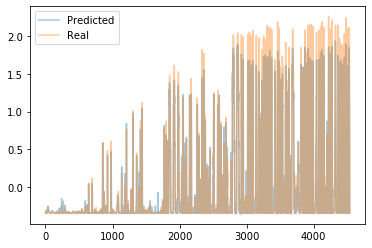

Training on dataframe: 10
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 495s 862ms/step - loss: 0.0979 - val_loss: 0.1261
MAE for the current dataframe: 0.12614500522613525
142/142 [==============================] - 20s 139ms/step


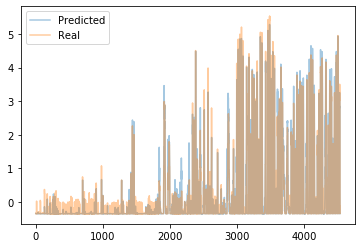

Training on dataframe: 13
Scaling data.
Creating the datacube.
Fitting the model
574/574 [==============================] - 451s 786ms/step - loss: 0.0337 - val_loss: 0.0377
MAE for the current dataframe: 0.03773362562060356
142/142 [==============================] - 20s 138ms/step


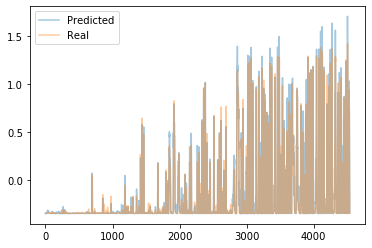

Training on dataframe: 14
Scaling data.
Creating the datacube.
Fitting the model
233/574 [===========>..................] - ETA: 4:34 - loss: 0.2273

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
  
lstm_output=['target']
batch_size=32
epochs=1
sampling_step=2000
T=24*3
models={}


for specific_value in ['0','1']:
    filtered_items = {key: value for key, value in df_dict.items() if specific_value in key}

    input_columns=lstm_inputs[specific_value]
    
    # Combine all dataframes for scaling
    combined_df = pd.concat([df.iloc[48:48+sampling_step] for df in filtered_items.values()], axis=0) 
    print(np.shape(combined_df))

    # Drop all NaN columns from the combined dataframe
    combined_df = combined_df.dropna(axis=1, how='all')
    input_columns = [col for col in input_columns if col in combined_df.columns]
    #input_columns=input_columns+lstm_output #in order to use the target as input up to time t-1. Managed in create lstm input. 
    print(input_columns)
    # Fit the scaler on the entire dataset
    scaler = StandardScaler()
    combined_df[input_columns+lstm_output] = scaler.fit_transform(combined_df[input_columns+lstm_output])


    # Initialize the LSTM model
    model=initialize_model(input_columns+lstm_output,lstm_output,200,120,T+1) #as the transformation is done, we need here T+1.


    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')

    print('Starting training')

    # Iterate over each dataframe in the dictionary for training
    for key, df in df_dict.items():
        print(f'Training on dataframe: {key}')

        # Apply the transformation with the fitted scaler
        temp_df=df
        df=df.dropna()
        
        #df=df[all_cols]
        df_output=df[lstm_output]
        print('Scaling data.')
        train_test = scaler.transform(df[input_columns+lstm_output].fillna(method='ffill'))
        train_test_df=pd.DataFrame(train_test,index=df.index,columns=input_columns+lstm_output)
        split_point = int(len(train_test_df) * 0.8)
        # Prepare input and output data
        train_features = train_test_df.iloc[:split_point]
        test_features = train_test_df.iloc[split_point:]
        
        print('Creating the datacube.')
        X_train,y_train = create_in_and_out_optimized(train_features,T,input_columns,lstm_output)
        X_val,y_val = create_in_and_out_optimized(test_features,T,input_columns,lstm_output)

        
        # Train the model on the data from the current dataframe
        print('Fitting the model')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)
        #grid_result = grid.fit(X_train, y_train)
        # Print the MAE for the last epoch
        last_mae = history.history['val_loss'][-1]
        print(f"MAE for the current dataframe: {last_mae}")
        y_pred=model.predict(X_val)
        plt.plot(y_pred, alpha=0.4,label='Predicted')
        plt.plot(y_val, alpha=0.4,label='Real')
        plt.legend()
        plt.show()
        
    model_dict={}
    model_dict['inputs']=input_columns
    model_dict['output']=lstm_output
    model_dict['model']=model
    model_dict['scaler']=scaler
    joblib.dump(model_dict, "./model_dict_{}_{}.pkl".format(specific_value,save_id))

print('Training completed.')

###the datacube cretion in quite long. Using the optimized version in much faster!



In [170]:
print(X[0,:,-1])
print(x['target_normalized'])

[ 2.28857363  2.28857363  2.28857363  2.28857363  0.35984339  0.35984339
  0.35984339  0.35984339  0.85938986  0.85938986  0.85938986  0.85938986
  1.19865405  1.19865405  1.19865405  1.19865405  0.68575072  0.68575072
  0.68575072  0.68575072 -0.31334223 -0.31334223 -0.31334223 -0.31334223
  2.28857363]
41    2.288574
42    2.288574
43    2.288574
44    2.288574
50    0.359843
51    0.359843
52    0.359843
49    0.359843
57    0.859390
59    0.859390
60    0.859390
58    0.859390
68    1.198654
67    1.198654
66    1.198654
65    1.198654
75    0.685751
74    0.685751
76    0.685751
73    0.685751
81   -0.313342
82   -0.313342
83   -0.313342
84   -0.313342
92    2.288574
Name: target_normalized, dtype: float64


In [148]:
#create_in_and_out(train_features,T,input_columns,lstm_output)



N = len(train_features) - T -1
D = len(input_columns+lstm_output)
X = np.zeros((N, T+1, D))
Y=np.zeros(N)
t=0
#for t in range(N):
x=train_features[input_columns].iloc[t:t+T+1] #all data from t to t+T included
print(np.shape(x))
x_tar=train_features[lstm_output].iloc[t:t+T]  #all targets ffrom t to t+T EXCLUDED
print(np.shape(x_tar))

x_tar=pd.concat([x_tar,pd.DataFrame(x_tar.iloc[0].values,columns=x_tar.columns)], ignore_index=True)#inpute the last value as the first to match dimensions
print(np.shape(x_tar))
display(x_tar)
#x=pd.concat([x,x_tar], ignore_index=True,axis=1) #unite the two
x[lstm_output]=x_tar.values
print(np.shape(x))
display(x)
X[t, :, :]=x.values

y=train_features[lstm_output].iloc[t+T]
Y[t]=y.values
     
    

(25, 21)
(24, 1)
(25, 1)


,target_normalized
0,2.288574
1,2.288574
2,2.288574
3,2.288574
4,0.359843
5,0.359843
6,0.359843
7,0.359843
8,0.859390
9,0.859390


(25, 22)


,county,weekday,hour_of_day,day_of_month,month,es_festive,eic_count,temperature_f,dewpoint_f,cloudcover_high_f,...,cloudcover_total_f,10_metre_u_wind_component_f,10_metre_v_wind_component_f,direct_solar_radiation_f,surface_solar_radiation_downwards_f,snowfall_f,total_precipitation_f,hours_ahead_f,euros_per_mwh,target_normalized
41,-2.0,-0.500628,0.377035,-1.340453,-1.056268,0.0,-19.032371,1.660744,-0.189501,-0.899340,...,-1.188335,1.051792,-2.165248,2.228580,2.325239,0.0,0.0,0.0,-0.227665,2.288574
42,-2.0,-0.500628,0.377035,-1.340453,-1.056268,0.0,-19.032371,1.660744,-0.189501,-0.899340,...,-1.188335,1.051792,-2.165248,2.228580,2.325239,0.0,0.0,0.0,-0.227665,2.288574
43,-2.0,-0.500628,0.377035,-1.340453,-1.056268,0.0,-19.032371,0.989311,1.814778,-0.899340,...,0.274595,-0.511333,0.237641,-0.520668,-0.610747,0.0,0.0,0.0,-0.227665,2.288574
44,-2.0,-0.500628,0.377035,-1.340453,-1.056268,0.0,-19.032371,0.989311,1.814778,-0.899340,...,0.274595,-0.511333,0.237641,-0.520668,-0.610747,0.0,0.0,0.0,-0.227665,2.288574
50,-2.0,-0.500628,0.519581,-1.340453,-1.056268,0.0,-19.032371,1.476545,-0.214801,-0.899340,...,-0.472433,0.864217,-2.087131,1.588169,1.281000,0.0,0.0,0.0,-0.226064,0.359843
51,-2.0,-0.500628,0.519581,-1.340453,-1.056268,0.0,-19.032371,1.206190,1.980630,-0.899340,...,0.399100,-0.476597,0.315758,0.336641,-0.207090,0.0,0.0,0.0,-0.226064,0.359843
52,-2.0,-0.500628,0.519581,-1.340453,-1.056268,0.0,-19.032371,1.206190,1.980630,-0.899340,...,0.399100,-0.476597,0.315758,0.336641,-0.207090,0.0,0.0,0.0,-0.226064,0.359843
49,-2.0,-0.500628,0.519581,-1.340453,-1.056268,0.0,-19.032371,1.476545,-0.214801,-0.899340,...,-0.472433,0.864217,-2.087131,1.588169,1.281000,0.0,0.0,0.0,-0.226064,0.359843
57,-2.0,-0.500628,0.662127,-1.340453,-1.056268,0.0,-19.032371,1.241841,-0.231667,-0.899340,...,-0.410181,0.624538,-2.024637,0.605256,0.303387,0.0,0.0,0.0,-0.175007,0.859390
59,-2.0,-0.500628,0.662127,-1.340453,-1.056268,0.0,-19.032371,1.622121,2.188648,-0.899340,...,-0.628064,-0.243865,0.247015,1.081338,0.611911,0.0,0.0,0.0,-0.175007,0.859390


In [93]:


for specific_value in ['0','1']:
    filtered_items = {key: value for key, value in df_dict.items() if specific_value in key}
    model_dict=joblib.load("./model_dict_{}_{}.pkl".format(specific_value,save_id))
    model=model_dict['model']
    scaler=model_dict['scaler']
    input_columns=model_dict['inputs']
    lstm_output=model_dict['output']
    
    for key, df in df_dict.items():
        print(f'Test on dataframe: {key}')

        # Apply the transformation with the fitted scaler
        temp_df=df
        df=df.dropna()
        all_cols=input_columns+lstm_output
        df=df[all_cols]
        y_real=df[lstm_output]
        train_test_df = scaler.transform(df[input_columns].fillna(method='ffill'))
        y_preds=[]
        X= create_lstm_input(train_test_df, T, -1)
        
        #for t in range(T,len(train_test_df)):
            #the output columns is the last
        y_pred=model.predict(X)
        #df[lstm_output]=y_pred.item()
        plt.plot(y_pred)
        plt.plot(y_real)
        plt.show()
            #display(y_pred)
        # Train the model on the data from the current dataframe

##TODO
# CAPIRE COME TRASFORMARE INPUT E OUTPUT NELLA STRUTTURA GIUSTA!



Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-12-23 23:22:40         3374
metadata.json                                  2023-12-23 23:22:40           64
variables.h5                                   2023-12-23 23:22:40      6305600
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
...

KeyboardInterrupt: 

In [71]:
print(np.shape(X_tot))
##NON TORNANO LE DIMENSIONI TRA X TOT, LEN(INPUT) ETC. 

(18416, 24, 24)


In [ ]:
###WITH GRIDSEARCH

def create_model(lstm_structure, dropout_rate):
    model = Sequential()
    for i, units in enumerate(lstm_structure):
        return_sequences = i < len(lstm_structure) - 1
        if i == 0:
            model.add(LSTM(units, return_sequences=return_sequences, input_shape=(1, len(input_columns))))
        else:
            model.add(LSTM(units, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(len(output_columns)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

param_grid = {
    'lstm_structure': [
        # Define your LSTM structures
        [60, 60, 60, 60], [120, 120, 120, 120],  # 4 layers
        #[30, 30, 30, 30, 30], [60, 60, 60, 60, 60], [90, 90, 90, 90, 90], [120, 120, 120, 120, 120] # 5 layers
    ],
    'dropout_rate': [0.2, 0.4],  # Different dropout rates
}

model = KerasRegressor(build_fn=create_model, epochs=100, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

print('Starting training')

for key, df in df_dict.items():
    print(f'Training on dataframe: {key}')

    # Apply the transformation with the fitted scaler
    temp_df=df
    df=df.dropna()
    df[input_columns] = scaler.transform(df[input_columns].fillna(method='ffill'))

    # Prepare input and output data
    X_scaled = df[input_columns].values.reshape(-1, 1, len(input_columns))
    y = df[output_columns].values

    # Split the data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    print(np.shape(X_scaled), len(input_columns))

    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    keras_model = grid_result.best_estimator_.model  # Get the underlying Keras model

    print("Best parameters: ", best_params)

print('Training completed.')

In [ ]:
###Prediction

Costruisci iterazione di prediction su t per t da 0 a 24 + merge target 
Ricostruisce 

In [4]:

lstm_inputs={}



lstm_input_0=['county',
'installed_capacity'
#'is_business',
#'product_type',
'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']
'''
'target_normalized_1',
'temperature_f_1',
'cloudcover_high_f_1',
'cloudcover_low_f_1',
'cloudcover_mid_f_1',
'cloudcover_total_f_1',
'direct_solar_radiation_f_1',
'snowfall_f_1',
'total_precipitation_f_1',
'target_normalized_2',
'temperature_f_2',
'cloudcover_high_f_2',
'cloudcover_low_f_2',
'cloudcover_mid_f_2',
'cloudcover_total_f_2',
'direct_solar_radiation_f_2',
'snowfall_f_2',
'total_precipitation_f_2',
'target_normalized_3',
'temperature_f_3',
'cloudcover_high_f_3',
'cloudcover_low_f_3',
'cloudcover_mid_f_3',
'cloudcover_total_f_3',
'direct_solar_radiation_f_3',
'snowfall_f_3',
'total_precipitation_f_3',
'target_normalized_4',
'temperature_f_4',
'cloudcover_high_f_4',
'cloudcover_low_f_4',
'cloudcover_mid_f_4',
'cloudcover_total_f_4',
'direct_solar_radiation_f_4',
'snowfall_f_4',
'total_precipitation_f_4',
'target_normalized_5',
'temperature_f_5',
'cloudcover_high_f_5',
'cloudcover_low_f_5',
'cloudcover_mid_f_5',
'cloudcover_total_f_5',
'direct_solar_radiation_f_5',
'snowfall_f_5',
'total_precipitation_f_5',
'target_normalized_6',
'temperature_f_6',
'cloudcover_high_f_6',
'cloudcover_low_f_6',
'cloudcover_mid_f_6',
'cloudcover_total_f_6',
'direct_solar_radiation_f_6',
'snowfall_f_6',
'total_precipitation_f_6',
'target_normalized_7',
'temperature_f_7',
'cloudcover_high_f_7',
'cloudcover_low_f_7',
'cloudcover_mid_f_7',
'cloudcover_total_f_7',
'direct_solar_radiation_f_7',
'snowfall_f_7',
'total_precipitation_f_7',
'target_normalized_8',
'temperature_f_8',
'cloudcover_high_f_8',
'cloudcover_low_f_8',
'cloudcover_mid_f_8',
'cloudcover_total_f_8',
'direct_solar_radiation_f_8',
'snowfall_f_8',
'total_precipitation_f_8',
'target_normalized_9',
'temperature_f_9',
'cloudcover_high_f_9',
'cloudcover_low_f_9',
'cloudcover_mid_f_9',
'cloudcover_total_f_9',
'direct_solar_radiation_f_9',
'snowfall_f_9',
'total_precipitation_f_9',
'target_normalized_10',
'temperature_f_10',
'cloudcover_high_f_10',
'cloudcover_low_f_10',
'cloudcover_mid_f_10',
'cloudcover_total_f_10',
'direct_solar_radiation_f_10',
'snowfall_f_10',
'total_precipitation_f_10',
'target_normalized_11',
'temperature_f_11',
'cloudcover_high_f_11',
'cloudcover_low_f_11',
'cloudcover_mid_f_11',
'cloudcover_total_f_11',
'direct_solar_radiation_f_11',
'snowfall_f_11',
'total_precipitation_f_11',
'target_normalized_12',
'temperature_f_12',
'cloudcover_high_f_12',
'cloudcover_low_f_12',
'cloudcover_mid_f_12',
'cloudcover_total_f_12',
'direct_solar_radiation_f_12',
'snowfall_f_12',
'total_precipitation_f_12',
'target_normalized_13',
'temperature_f_13',
'cloudcover_high_f_13',
'cloudcover_low_f_13',
'cloudcover_mid_f_13',
'cloudcover_total_f_13',
'direct_solar_radiation_f_13',
'snowfall_f_13',
'total_precipitation_f_13',
'target_normalized_14',
'temperature_f_14',
'cloudcover_high_f_14',
'cloudcover_low_f_14',
'cloudcover_mid_f_14',
'cloudcover_total_f_14',
'direct_solar_radiation_f_14',
'snowfall_f_14',
'total_precipitation_f_14',
'target_normalized_15',
'temperature_f_15',
'cloudcover_high_f_15',
'cloudcover_low_f_15',
'cloudcover_mid_f_15',
'cloudcover_total_f_15',
'direct_solar_radiation_f_15',
'snowfall_f_15',
'total_precipitation_f_15',
'target_normalized_16',
'temperature_f_16',
'cloudcover_high_f_16',
'cloudcover_low_f_16',
'cloudcover_mid_f_16',
'cloudcover_total_f_16',
'direct_solar_radiation_f_16',
'snowfall_f_16',
'total_precipitation_f_16',
'target_normalized_17',
'temperature_f_17',
'cloudcover_high_f_17',
'cloudcover_low_f_17',
'cloudcover_mid_f_17',
'cloudcover_total_f_17',
'direct_solar_radiation_f_17',
'snowfall_f_17',
'total_precipitation_f_17',
'target_normalized_18',
'temperature_f_18',
'cloudcover_high_f_18',
'cloudcover_low_f_18',
'cloudcover_mid_f_18',
'cloudcover_total_f_18',
'direct_solar_radiation_f_18',
'snowfall_f_18',
'total_precipitation_f_18',
'target_normalized_19',
'temperature_f_19',
'cloudcover_high_f_19',
'cloudcover_low_f_19',
'cloudcover_mid_f_19',
'cloudcover_total_f_19',
'direct_solar_radiation_f_19',
'snowfall_f_19',
'total_precipitation_f_19',
'target_normalized_20',
'temperature_f_20',
'cloudcover_high_f_20',
'cloudcover_low_f_20',
'cloudcover_mid_f_20',
'cloudcover_total_f_20',
'direct_solar_radiation_f_20',
'snowfall_f_20',
'total_precipitation_f_20',
'target_normalized_21',
'temperature_f_21',
'cloudcover_high_f_21',
'cloudcover_low_f_21',
'cloudcover_mid_f_21',
'cloudcover_total_f_21',
'direct_solar_radiation_f_21',
'snowfall_f_21',
'total_precipitation_f_21',
'target_normalized_22',
'temperature_f_22',
'cloudcover_high_f_22',
'cloudcover_low_f_22',
'cloudcover_mid_f_22',
'cloudcover_total_f_22',
'direct_solar_radiation_f_22',
'snowfall_f_22',
'total_precipitation_f_22',
'target_normalized_23',
'temperature_f_23',
'cloudcover_high_f_23',
'cloudcover_low_f_23',
'cloudcover_mid_f_23',
'cloudcover_total_f_23',
'direct_solar_radiation_f_23',
'snowfall_f_23',
'total_precipitation_f_23',
'target_normalized_24',
'temperature_f_24',
'cloudcover_high_f_24',
'cloudcover_low_f_24',
'cloudcover_mid_f_24',
'cloudcover_total_f_24',
'direct_solar_radiation_f_24',
'snowfall_f_24',
'total_precipitation_f_24',
'es_festive_24']
'''

lstm_input_1=['county',
#'installed_capacity'
'is_business',
'product_type',
'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']
'''
'target_normalized_1',
'temperature_f_1',
'cloudcover_high_f_1',
'cloudcover_low_f_1',
'cloudcover_mid_f_1',
'cloudcover_total_f_1',
'direct_solar_radiation_f_1',
'snowfall_f_1',
'total_precipitation_f_1',
'target_normalized_2',
'temperature_f_2',
'cloudcover_high_f_2',
'cloudcover_low_f_2',
'cloudcover_mid_f_2',
'cloudcover_total_f_2',
'direct_solar_radiation_f_2',
'snowfall_f_2',
'total_precipitation_f_2',
'target_normalized_3',
'temperature_f_3',
'cloudcover_high_f_3',
'cloudcover_low_f_3',
'cloudcover_mid_f_3',
'cloudcover_total_f_3',
'direct_solar_radiation_f_3',
'snowfall_f_3',
'total_precipitation_f_3',
'target_normalized_4',
'temperature_f_4',
'cloudcover_high_f_4',
'cloudcover_low_f_4',
'cloudcover_mid_f_4',
'cloudcover_total_f_4',
'direct_solar_radiation_f_4',
'snowfall_f_4',
'total_precipitation_f_4',
'target_normalized_5',
'temperature_f_5',
'cloudcover_high_f_5',
'cloudcover_low_f_5',
'cloudcover_mid_f_5',
'cloudcover_total_f_5',
'direct_solar_radiation_f_5',
'snowfall_f_5',
'total_precipitation_f_5',
'target_normalized_6',
'temperature_f_6',
'cloudcover_high_f_6',
'cloudcover_low_f_6',
'cloudcover_mid_f_6',
'cloudcover_total_f_6',
'direct_solar_radiation_f_6',
'snowfall_f_6',
'total_precipitation_f_6',
'target_normalized_7',
'temperature_f_7',
'cloudcover_high_f_7',
'cloudcover_low_f_7',
'cloudcover_mid_f_7',
'cloudcover_total_f_7',
'direct_solar_radiation_f_7',
'snowfall_f_7',
'total_precipitation_f_7',
'target_normalized_8',
'temperature_f_8',
'cloudcover_high_f_8',
'cloudcover_low_f_8',
'cloudcover_mid_f_8',
'cloudcover_total_f_8',
'direct_solar_radiation_f_8',
'snowfall_f_8',
'total_precipitation_f_8',
'target_normalized_9',
'temperature_f_9',
'cloudcover_high_f_9',
'cloudcover_low_f_9',
'cloudcover_mid_f_9',
'cloudcover_total_f_9',
'direct_solar_radiation_f_9',
'snowfall_f_9',
'total_precipitation_f_9',
'target_normalized_10',
'temperature_f_10',
'cloudcover_high_f_10',
'cloudcover_low_f_10',
'cloudcover_mid_f_10',
'cloudcover_total_f_10',
'direct_solar_radiation_f_10',
'snowfall_f_10',
'total_precipitation_f_10',
'target_normalized_11',
'temperature_f_11',
'cloudcover_high_f_11',
'cloudcover_low_f_11',
'cloudcover_mid_f_11',
'cloudcover_total_f_11',
'direct_solar_radiation_f_11',
'snowfall_f_11',
'total_precipitation_f_11',
'target_normalized_12',
'temperature_f_12',
'cloudcover_high_f_12',
'cloudcover_low_f_12',
'cloudcover_mid_f_12',
'cloudcover_total_f_12',
'direct_solar_radiation_f_12',
'snowfall_f_12',
'total_precipitation_f_12',
'target_normalized_13',
'temperature_f_13',
'cloudcover_high_f_13',
'cloudcover_low_f_13',
'cloudcover_mid_f_13',
'cloudcover_total_f_13',
'direct_solar_radiation_f_13',
'snowfall_f_13',
'total_precipitation_f_13',
'target_normalized_14',
'temperature_f_14',
'cloudcover_high_f_14',
'cloudcover_low_f_14',
'cloudcover_mid_f_14',
'cloudcover_total_f_14',
'direct_solar_radiation_f_14',
'snowfall_f_14',
'total_precipitation_f_14',
'target_normalized_15',
'temperature_f_15',
'cloudcover_high_f_15',
'cloudcover_low_f_15',
'cloudcover_mid_f_15',
'cloudcover_total_f_15',
'direct_solar_radiation_f_15',
'snowfall_f_15',
'total_precipitation_f_15',
'target_normalized_16',
'temperature_f_16',
'cloudcover_high_f_16',
'cloudcover_low_f_16',
'cloudcover_mid_f_16',
'cloudcover_total_f_16',
'direct_solar_radiation_f_16',
'snowfall_f_16',
'total_precipitation_f_16',
'target_normalized_17',
'temperature_f_17',
'cloudcover_high_f_17',
'cloudcover_low_f_17',
'cloudcover_mid_f_17',
'cloudcover_total_f_17',
'direct_solar_radiation_f_17',
'snowfall_f_17',
'total_precipitation_f_17',
'target_normalized_18',
'temperature_f_18',
'cloudcover_high_f_18',
'cloudcover_low_f_18',
'cloudcover_mid_f_18',
'cloudcover_total_f_18',
'direct_solar_radiation_f_18',
'snowfall_f_18',
'total_precipitation_f_18',
'target_normalized_19',
'temperature_f_19',
'cloudcover_high_f_19',
'cloudcover_low_f_19',
'cloudcover_mid_f_19',
'cloudcover_total_f_19',
'direct_solar_radiation_f_19',
'snowfall_f_19',
'total_precipitation_f_19',
'target_normalized_20',
'temperature_f_20',
'cloudcover_high_f_20',
'cloudcover_low_f_20',
'cloudcover_mid_f_20',
'cloudcover_total_f_20',
'direct_solar_radiation_f_20',
'snowfall_f_20',
'total_precipitation_f_20',
'target_normalized_21',
'temperature_f_21',
'cloudcover_high_f_21',
'cloudcover_low_f_21',
'cloudcover_mid_f_21',
'cloudcover_total_f_21',
'direct_solar_radiation_f_21',
'snowfall_f_21',
'total_precipitation_f_21',
'target_normalized_22',
'temperature_f_22',
'cloudcover_high_f_22',
'cloudcover_low_f_22',
'cloudcover_mid_f_22',
'cloudcover_total_f_22',
'direct_solar_radiation_f_22',
'snowfall_f_22',
'total_precipitation_f_22',
'target_normalized_23',
'temperature_f_23',
'cloudcover_high_f_23',
'cloudcover_low_f_23',
'cloudcover_mid_f_23',
'cloudcover_total_f_23',
'direct_solar_radiation_f_23',
'snowfall_f_23',
'total_precipitation_f_23',
'target_normalized_24',
'temperature_f_24',
'cloudcover_high_f_24',
'cloudcover_low_f_24',
'cloudcover_mid_f_24',
'cloudcover_total_f_24',
'direct_solar_radiation_f_24',
'snowfall_f_24',
'total_precipitation_f_24']
'''


lstm_inputs['0']=lstm_input_0
lstm_inputs['1']=lstm_input_1